In [1]:
import os
import gc
from tqdm import tqdm
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import math

# %matplotlib widget
basePath = "./sims.TNG/TNG100-1/output"

initial_snapshot = 69
end_snapshot = 99

halos_fields = ["GroupFirstSub", "GroupNsubs", "GroupMass", "GroupPos"]
subhalos_fields = ["SubhaloGrNr", "SubhaloMass", "SubhaloPos"]
tree_fields = ["SubfindID", "SnapNum"]

h = 0.6774  # km/Mpc

m_dm = 4.5e-5  # E10M_Sum
m_dm_h = m_dm * h

Critial_Density = 1.27e-8  # E10M_Sum/kpc^3
Critial_Density_h = Critial_Density / h**2  # E10M_Sum/(kpc/h)^3


def Detect_Mkdir(Path):
    if not (os.path.exists(Path)):
        os.makedirs(Path)
    return Path


FilePath = Detect_Mkdir(os.path.join('./TNG100_Final_File'))
Final_File_List = ['Halo_Array', 'Host_Array', 'MMS_Array', 'First_App_Snap_Array', 'First_App_Distance_Array',
                   'Snap99_Distance_Array', 'Snap99_Radial_Velocity_Array', 'Snap99_Virial_Radius_Array', 'Is_First_Approach', 'Is_First_Infall']
for filename in Final_File_List:
    if os.path.exists(os.path.join(FilePath, filename)+'.npy'):
        globals()[filename] = np.load(
            (os.path.join(FilePath, filename)+'.npy'))


In [ ]:
Age_Array = np.array([
    0.179, 0.271, 0.37, 0.418, 0.475, 0.517, 0.547, 0.596, 0.64, 0.687,
    0.732, 0.764, 0.844, 0.932, 0.965, 1.036, 1.112, 1.177, 1.282, 1.366,
    1.466, 1.54, 1.689, 1.812, 1.944, 2.145, 2.238, 2.384, 2.539, 2.685,
    2.839, 2.981, 3.129, 3.285, 3.447, 3.593, 3.744, 3.902, 4.038, 4.206,
    4.293, 4.502, 4.657, 4.816, 4.98, 5.115, 5.289, 5.431, 5.577, 5.726,
    5.878, 6.073, 6.193, 6.356, 6.522, 6.692, 6.822, 6.998, 7.132, 7.314,
    7.453, 7.642, 7.786, 7.932, 8.079, 8.28, 8.432, 8.587, 8.743, 8.902,
    9.062, 9.225, 9.389, 9.556, 9.724, 9.837, 10.009, 10.182, 10.299,
    10.535, 10.654, 10.834, 11.016, 11.138, 11.323, 11.509, 11.635,
    11.824, 11.951, 12.143, 12.337, 12.467, 12.663, 12.795, 12.993,
    13.127, 13.328, 13.463, 13.667, 13.803
])

Snapshot_Array=np.arange(0,100)


In [2]:
def Calculate_Halo_Dict(halo_index, host_index, mms_index):

    host_tree = il.sublink.loadTree(
        basePath, end_snapshot, host_index, fields=tree_fields, onlyMPB=1)
    mms_tree = il.sublink.loadTree(
        basePath, end_snapshot, mms_index, fields=tree_fields, onlyMPB=1)

    satellite_velocity_list = list()
    host_mms_distance = list()
    host_position_list = list()
    mms_position_list = list()

    for current_snapshot in range(initial_snapshot, end_snapshot+1):

        header = il.groupcat.loadHeader(basePath, current_snapshot)
        scale_factor = header['Time']
        host_subhalo_index = host_tree['SubfindID'][np.where(
            host_tree['SnapNum'] == current_snapshot)[0]]
        mms_subhalo_index = mms_tree['SubfindID'][np.where(
            mms_tree['SnapNum'] == current_snapshot)[0]]

        if len(mms_subhalo_index) == 0 or len(host_subhalo_index) == 0:
            satellite_velocity_list.append(0)
            host_mms_distance.append(0)
            host_position_list.append(np.array([0, 0, 0]))
            mms_position_list.append(np.array([0, 0, 0]))
            continue

        host_subhalo_dict = il.groupcat.loadSingle(
            basePath, current_snapshot, -1, host_subhalo_index)
        mms_subhalo_dict = il.groupcat.loadSingle(
            basePath, current_snapshot, -1, mms_subhalo_index)

        current_host_comoving_position = host_subhalo_dict['SubhaloPos']
        current_mms_comoving_position = mms_subhalo_dict['SubhaloPos']

        current_host_physical_position = current_host_comoving_position*scale_factor
        current_mms_physical_position = current_mms_comoving_position*scale_factor

        current_host_physical_position = current_host_physical_position % 35000
        current_mms_physical_position = current_mms_physical_position % 35000

        current_difference_physical_coordinates = current_mms_physical_position - \
            current_host_physical_position
        distance = np.linalg.norm(current_difference_physical_coordinates)

        host_velocity = host_subhalo_dict['SubhaloVel']
        mms_velocity = mms_subhalo_dict['SubhaloVel']

        Vel_diff = mms_velocity-host_velocity
        Vel_Radius = np.dot(
            Vel_diff, current_difference_physical_coordinates)/distance

        satellite_velocity_list.append(Vel_Radius)
        host_mms_distance.append(distance)

        host_position_list.append(current_host_physical_position)
        mms_position_list.append(current_mms_physical_position)

        gc.collect()
    satellite_radius_velocity = np.array(satellite_velocity_list)
    host_mms_distance = np.array(host_mms_distance)
    host_position_array = np.array(host_position_list)
    mms_position_array = np.array(mms_position_list)

    return_data = dict()
    return_data['Host_Index'] = host_index
    return_data['MMS_Index'] = mms_index
    return_data['Halo_Index'] = halo_index
    return_data['RadialVelocity'] = satellite_radius_velocity
    return_data['Distance'] = host_mms_distance
    return_data['HostPosition'] = host_position_array
    return_data['MMSPosition'] = mms_position_array
    return_data['Snapshots'] = np.arange(initial_snapshot, end_snapshot+1)
    return return_data





def Calculate_Radial_Velocity(halo_index):
    halo_dict = il.groupcat.loadSingle(basePath, end_snapshot, halo_index, -1)
    if halo_dict['GroupFirstSub'] == -1:
        return -1
    if halo_dict['GroupNsubs'] == -1:
        return -1

    subhalos_masses_list = list()

    for subhalo_index in range(halo_dict['GroupFirstSub'], halo_dict['GroupFirstSub']+halo_dict['GroupNsubs']):
        subhalos_masses_list.append(subhalos_mass[subhalo_index])

    subhalos_masses_array = np.array(subhalos_masses_list)

    del subhalos_masses_list
    gc.collect()

    host_index = halo_dict['GroupFirstSub'] + \
        np.argsort(subhalos_masses_array)[-1]
    mms_index = halo_dict['GroupFirstSub'] + \
        np.argsort(subhalos_masses_array)[-2]

    host_tree = il.sublink.loadTree(
        basePath, end_snapshot, host_index, fields=tree_fields, onlyMPB=1)
    mms_tree = il.sublink.loadTree(
        basePath, end_snapshot, mms_index, fields=tree_fields, onlyMPB=1)

    satellite_velocity_list = list()
    host_mms_distance = list()
    host_position_list = list()
    mms_position_list = list()

    for current_snapshot in range(initial_snapshot, end_snapshot+1):

        header = il.groupcat.loadHeader(basePath, current_snapshot)
        scale_factor = header['Time']
        host_subhalo_index = host_tree['SubfindID'][np.where(
            host_tree['SnapNum'] == current_snapshot)[0]]
        mms_subhalo_index = mms_tree['SubfindID'][np.where(
            mms_tree['SnapNum'] == current_snapshot)[0]]

        if len(mms_subhalo_index) == 0 or len(host_subhalo_index) == 0:
            satellite_velocity_list.append(0)
            host_mms_distance.append(0)
            host_position_list.append(np.array([0, 0, 0]))
            mms_position_list.append(np.array([0, 0, 0]))
            continue

        host_subhalo_dict = il.groupcat.loadSingle(
            basePath, current_snapshot, -1, host_subhalo_index)
        mms_subhalo_dict = il.groupcat.loadSingle(
            basePath, current_snapshot, -1, mms_subhalo_index)

        current_host_comoving_position = host_subhalo_dict['SubhaloPos']
        current_mms_comoving_position = mms_subhalo_dict['SubhaloPos']

        current_host_physical_position = current_host_comoving_position*scale_factor
        current_mms_physical_position = current_mms_comoving_position*scale_factor

        current_host_physical_position = current_host_physical_position % 35000
        current_mms_physical_position = current_mms_physical_position % 35000

        current_difference_physical_coordinates = current_mms_physical_position - \
            current_host_physical_position
        distance = np.linalg.norm(current_difference_physical_coordinates)

        host_velocity = host_subhalo_dict['SubhaloVel']
        mms_velocity = mms_subhalo_dict['SubhaloVel']

        Vel_diff = mms_velocity-host_velocity
        Vel_Radius = np.dot(
            Vel_diff, current_difference_physical_coordinates)/distance

        satellite_velocity_list.append(Vel_Radius)
        host_mms_distance.append(distance)

        host_position_list.append(current_host_physical_position)
        mms_position_list.append(current_mms_physical_position)

        gc.collect()
    satellite_radius_velocity = np.array(satellite_velocity_list)
    host_mms_distance = np.array(host_mms_distance)
    host_position_array = np.array(host_position_list)
    mms_position_array = np.array(mms_position_list)

    return_data = dict()
    return_data['Host_Index'] = host_index
    return_data['MMS_Index'] = mms_index
    return_data['Halo_Index'] = halo_index
    return_data['RadialVelocity'] = satellite_radius_velocity
    return_data['Distance'] = host_mms_distance
    return_data['HostPosition'] = host_position_array
    return_data['MMSPosition'] = mms_position_array
    return_data['Snapshots'] = np.arange(initial_snapshot, end_snapshot+1)
    return return_data


def Extremum_Calculation(Distance_Array, Virial_Radius):
    Extremum_Number = 0
    for index in np.arange(1, len(Distance_Array)-1):
        if (Distance_Array[index-1]-Distance_Array[index])*(Distance_Array[index]-Distance_Array[index+1]) < 0 and Distance_Array[index] <= 2*Virial_Radius:
            Extremum_Number += 1
    return Extremum_Number


def Distance_Plot(Halo_Dict, SavePath, Virial_Radius=None):
    halo_index = Halo_Dict['Halo_Index']
    plt.figure(figsize=(8, 6))
    plt.plot(Halo_Dict['Snapshots'], Halo_Dict['Distance'])
    plt.grid()
    plt.xlabel('Snapshot')
    plt.ylabel('Satellite-Host Distance (kpc/h)')
    plt.title(f'Distance Evolution of Halo-{halo_index}')
    if Virial_Radius is not None:
        # Add a horizontal dashed line to represent the Virial Radius
        plt.axhline(y=Virial_Radius, color='red',
                    linestyle='--', label='Virial Radius')
    plt.savefig(os.path.join(
        SavePath, f'Halo-{halo_index} Distance Evolution'))
    plt.close('all')
    gc.collect()


def OrbitTrajectory3D_Plot(Halo_Dict, SavePath):
    halo_index = Halo_Dict['Halo_Index']
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection='3d')
    ax.set_box_aspect([1, 1, 1])
    ax.grid(True, linestyle='--', alpha=0.5)

    x = Halo_Dict['MMSPosition'][:, 0]-Halo_Dict['HostPosition'][:, 0]
    y = Halo_Dict['MMSPosition'][:, 1]-Halo_Dict['HostPosition'][:, 1]
    z = Halo_Dict['MMSPosition'][:, 2]-Halo_Dict['HostPosition'][:, 2]
    ax.plot3D(x, y, z)
    ax.set_title(f'Halo-{halo_index} Orbit Trajectory')
    ax.scatter(0, 0, 0, color='black', s=20)
    max_range = max(max(x), max(y), max(z))
    min_range = min(min(x), min(y), min(z))
    ax.set_xlim(min_range, max_range)
    ax.set_ylim(min_range, max_range)
    ax.set_zlim(min_range, max_range)
    ax.set_xlabel('X (kpc/h)')
    ax.set_ylabel('Y (kpc/h)')
    ax.set_zlabel('Z (kpc/h)')
    for i in range(initial_snapshot, initial_snapshot+len(x), 5):
        ax.text(x[i-initial_snapshot], y[i-initial_snapshot],
                z[i-initial_snapshot], f'Snap-{i}', color='black', fontsize=10)
    plt.savefig(os.path.join(SavePath, f'Halo-{halo_index} Orbit Trajectory'))
    plt.close('all')
    gc.collect()


def Orbit_Trajectory_Plot(Array1, Array2, Label1, Label2, SavePath, Halo_Index, Virial_Radius):
    plt.figure(figsize=(8, 6))
    plt.plot(Array1, Array2)
    plt.scatter(0, 0, c='black', s=20)

    # Add a red dashed circle with Virial Radius
    circle = plt.Circle((0, 0), Virial_Radius, color='red',
                        fill=False, linestyle='--')
    plt.gca().add_patch(circle)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.xlabel(Label1 + ' (kpc/h)')
    plt.ylabel(Label2 + ' (kpc/h)')
    plt.title(f'Halo-{Halo_Index} ' + Label1 + '-' +
              Label2 + ' Plane Orbit Trajectory')

    for i in range(initial_snapshot, initial_snapshot + len(Array1), 5):
        plt.text(Array1[i - initial_snapshot], Array2[i - initial_snapshot],
                 f'Snap-{i}', color='black', fontsize=9)

    # Annotate Virial Radius
    plt.text(Virial_Radius, 0, f'Virial Radius', color='red',
             fontsize=9, verticalalignment='bottom')

    plt.savefig(os.path.join(
        SavePath, f'Halo-{Halo_Index} ' + Label1 + '-' + Label2 + ' Plane Orbit Trajectory'))
    plt.close('all')
    gc.collect()


def RadialVelocity_Plot(Halo_Dict, SavePath):
    halo_index = Halo_Dict['Halo_Index']
    plt.figure(figsize=(8, 6))
    plt.plot(Halo_Dict['Snapshots'], Halo_Dict['RadialVelocity'])
    plt.grid()
    plt.xlabel('Snapshot')
    plt.ylabel('MMS Radial Velocity (km/s)')
    plt.title(f'Radial Velocity Evolution of Halo-{halo_index}')
    plt.axhline(0, color='red', linestyle='--')  # 添加y=0的水平线
    plt.savefig(os.path.join(
        SavePath, f'Halo-{halo_index} Radial Velocity Evolution'))
    plt.close('all')
    gc.collect()


def OrbitTrajectory2D_Plot(Halo_Dict, SavePath, Virial_Radius):
    halo_index = Halo_Dict['Halo_Index']
    x = Halo_Dict['MMSPosition'][:, 0]-Halo_Dict['HostPosition'][:, 0]
    y = Halo_Dict['MMSPosition'][:, 1]-Halo_Dict['HostPosition'][:, 1]
    z = Halo_Dict['MMSPosition'][:, 2]-Halo_Dict['HostPosition'][:, 2]

    Orbit_Trajectory_Plot(x, y, 'X', 'Y', Detect_Mkdir(
        os.path.join(SavePath, 'XY-Trajectory')), halo_index, Virial_Radius)
    Orbit_Trajectory_Plot(y, z, 'Y', 'Z', Detect_Mkdir(
        os.path.join(SavePath, 'YZ-Trajectory')), halo_index, Virial_Radius)
    Orbit_Trajectory_Plot(x, z, 'X', 'Z', Detect_Mkdir(
        os.path.join(SavePath, 'XZ-Trajectory')), halo_index, Virial_Radius)

    gc.collect()


In [3]:
virial_radius = il.groupcat.loadHalos(basePath, 99, fields=['Group_R_Crit200'])


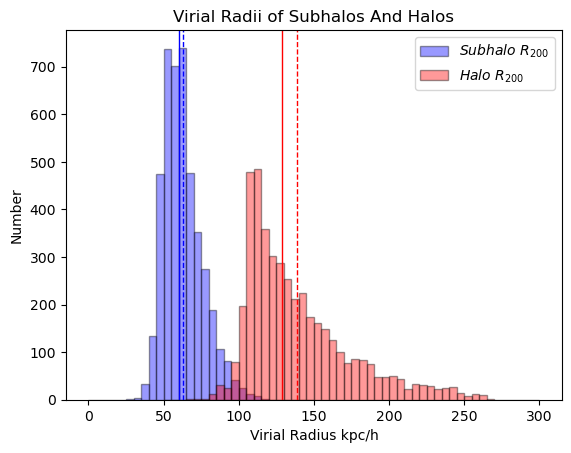

In [21]:
plt.hist(Snap99_Virial_Radius_Array, bins=30, range=[
         0, 150], histtype='bar', edgecolor='black', color='blue', alpha=0.4, label='$Subhalo\ R_{200}$')
plt.hist(virial_radius[Halo_Array], bins=50, range=[50, 300], histtype='bar',
         edgecolor='black', color='red', alpha=0.4, label='$Halo\ R_{200}$')
plt.legend()
plt.xlabel('Virial Radius kpc/h')
plt.ylabel('Number')
plt.title('Virial Radii of Subhalos And Halos')
plt.axvline(x=Snap99_Virial_Radius_Array.mean(), color='blue', linestyle='dashed',
                linewidth=1)
plt.axvline(x=np.median(Snap99_Virial_Radius_Array), color='blue', linestyle='solid',
                linewidth=1)
plt.axvline(x=np.median(virial_radius[Halo_Array]), color='red', linestyle='solid',
                linewidth=1)
plt.axvline(x=virial_radius[Halo_Array].mean(), color='red', linestyle='dashed',
                linewidth=1)


In [9]:
FilePath = Detect_Mkdir(os.path.join('./TNG100_Final_File'))
filename = 'Is_First_Infall'
if os.path.exists(os.path.join(FilePath, filename)+'.npy'):
    globals()[filename] = np.load(
        (os.path.join(FilePath, filename)+'.npy'))
else:
    Is_First_Infall = np.array([])

start_sub_index = Is_First_Infall.shape[0]
step_length = 100
end = start_sub_index+step_length

if end > Halo_Array.shape[0]:
    end = Halo_Array.shape[0]
Final_File_Is_First_Infall = list()

for Subindex in tqdm(range(start_sub_index, end)):
    Halo_Index = Halo_Array[Subindex]
    Host_Index = Host_Array[Subindex]
    MMS_Index = MMS_Array[Subindex]

    halo_dict = Calculate_Halo_Dict(Halo_Index, Host_Index, MMS_Index)
    If_Distance_99_Within_2VirialRadius = (
        halo_dict['Distance'][end_snapshot-initial_snapshot] <= 2*Snap99_Virial_Radius_Array[Subindex])
    If_Extremun_Num_Less_2 = (Extremum_Calculation(
        halo_dict['Distance'], Snap99_Virial_Radius_Array[Subindex]) <= 1)
    If_First_Infall = If_Distance_99_Within_2VirialRadius and If_Extremun_Num_Less_2
    Final_File_Is_First_Infall.append(If_First_Infall)


Final_File_Is_First_Infall_Array = np.array(Final_File_Is_First_Infall)


100%|██████████| 100/100 [06:45<00:00,  4.06s/it]


In [10]:
print(Halo_Array[:100][Final_File_Is_First_Infall_Array])
print(Host_Array[:100][Final_File_Is_First_Infall_Array])
print(MMS_Array[:100][Final_File_Is_First_Infall_Array])


[349 367 369 377 410 419 424 425 430 436 437]
[367456 371704 372175 373951 380934 382921 383945 384103 385115 386429
 386612]
[367457 371705 372176 373952 380937 382922 383946 384105 385116 386430
 386613]


In [46]:
Halo_Array


array([ 305,  328,  329, ..., 5077, 5087, 5537])

In [ ]:

if os.path.exists(os.path.join(FilePath, filename)+'.npy'):
    Previous_File = np.load((os.path.join(FilePath, filename)+'.npy'))
    Next_File_Name = 'Final_File_'+filename
    Next_File_Array = globals()[Next_File_Name]
    ConCated_File = np.concatenate(
        (Previous_File, Next_File_Array), axis=0)
    np.save((os.path.join(FilePath, filename)+'.npy'), ConCated_File)
else:
    File_Name = 'Final_File_'+filename
    File_Array = globals()[File_Name]
    np.save((os.path.join(FilePath, filename)+'.npy'), File_Array)
